In [2]:
# import in the necessary libraries

import yfinance as yf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

In [96]:
# Read in data from necessary tickers
tickers = yf.Tickers('NBS.L VMUK.L HSBA.L RBSPF BNC.L')
df_nw = tickers.tickers['NBS.L'].history(period='5y')
df_virgin = tickers.tickers['VMUK.L'].history(period='5y')
df_hsbc = tickers.tickers['HSBA.L'].history(period='5y')
df_rbs = tickers.tickers['RBSPF'].history(period='5y')
df_santendar = tickers.tickers['BNC.L'].history(period='5y')

In [97]:
tickers = {'nationwide': df_nw, 'virgin': df_virgin, 'hsbc': df_hsbc, 'rbs' : df_rbs, 'santendar': df_santendar}

for keys, values in tickers.items(): 
    values.index = pd.to_datetime(values.index).date
    print(keys, values.index.dtype)
    values.rename(columns={'Close': f'{keys.title()}_Close'}, inplace=True)

nationwide object
virgin object
hsbc object
rbs object
santendar object


In [6]:
daterange = pd.date_range(end=pd.Timestamp.today(), periods=5*365, freq='B')
df_all = pd.DataFrame(index=daterange)
df_all.index = df_all.index.date
for key, values in tickers.items():
    print(key,values.index.dtype)
    df_all = pd.merge(df_all, values[f'{key.title()}_Close'], how='left', left_index=True, right_index=True)
    
df_all = df_all.dropna()

nationwide object
virgin object
hsbc object
rbs object
santendar object


In [98]:
# delve into the data - plot all the data on one graph:
# just doing this the quick and dirty way... we see that there are big discrepencies in the data, and so it's important to normalise the data
# look back over normalisation notes
## z-score normalisation, min-max scaling, log transformation, percentage change, robust scaling

for i in df_all.columns:
    df_all[f'Percentage_change_{i.split("_")[0]}'] = df_all[i].pct_change().mul(100)

Text(0.5, 0.98, 'Percentage change over time in NW, Virgin, HSBC, RBS')

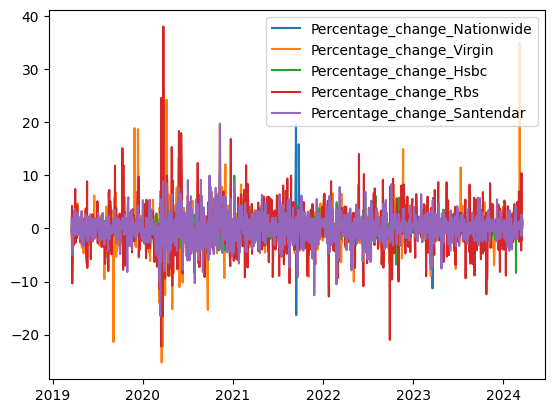

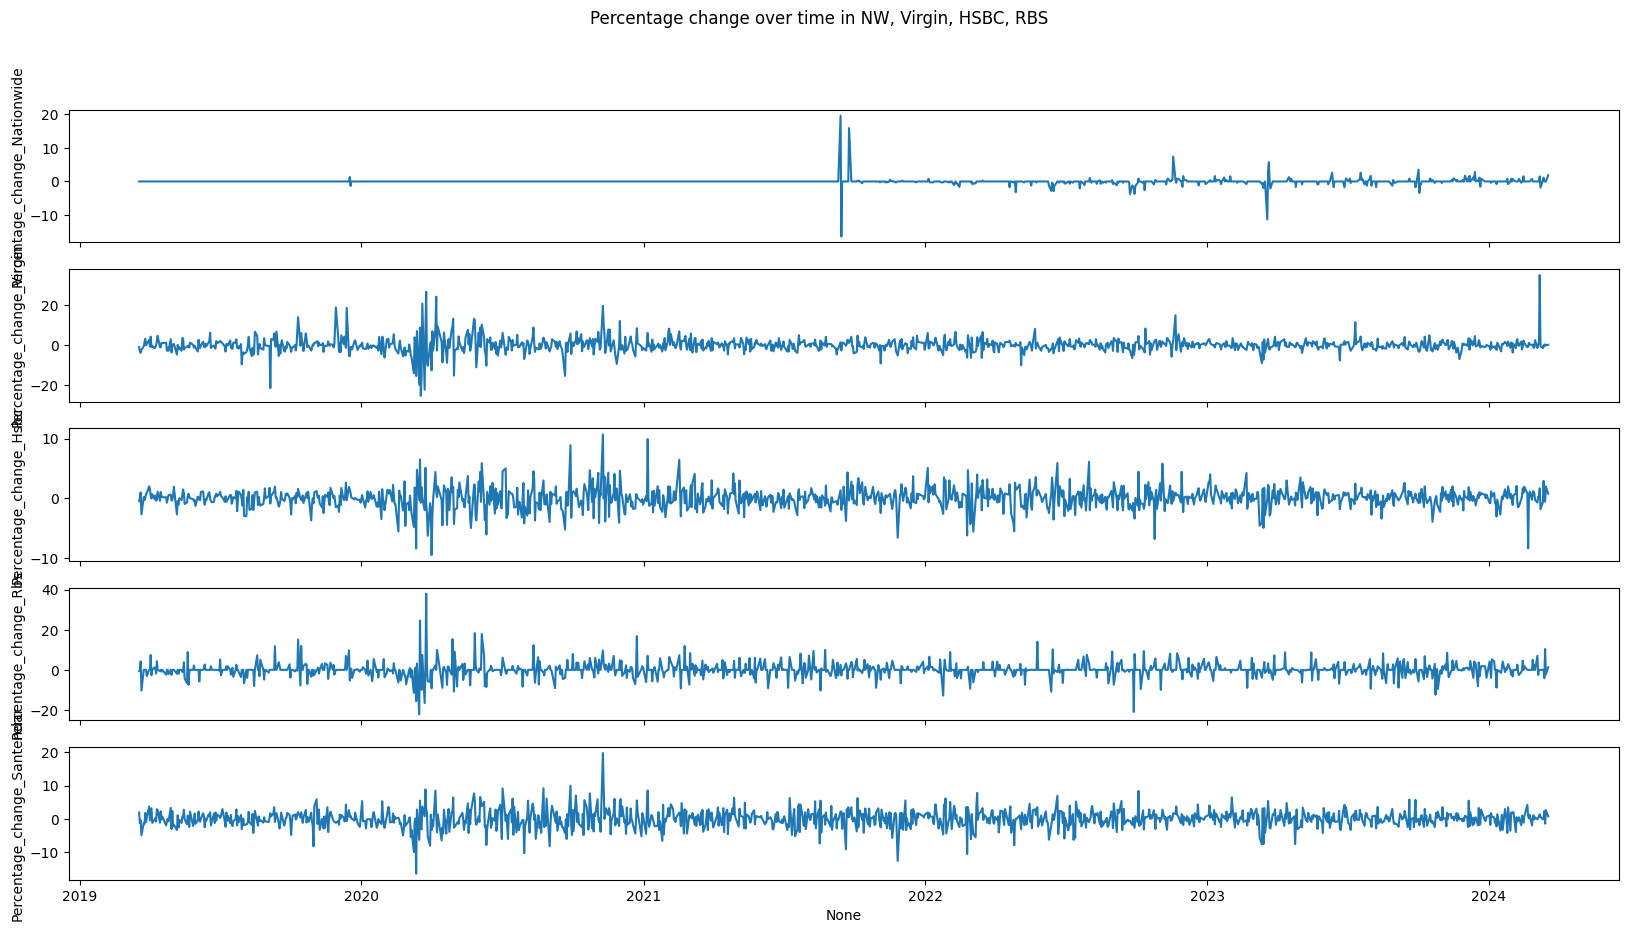

In [99]:
# select the columns referring to returns and plot them 
# view all of the data in one graph 

df_all.iloc[:, 5:-1][1:].plot()

# hard to understand, can we create subplots?

fig, axs = plt.subplots(5,1, figsize=(20,10), sharex=True)
sns.lineplot(data=df_all, x=df_all.index, y='Percentage_change_Nationwide', ax=axs[0])
sns.lineplot(data=df_all, x=df_all.index, y='Percentage_change_Virgin', ax=axs[1])
sns.lineplot(data=df_all, x=df_all.index, y='Percentage_change_Hsbc', ax=axs[2])
sns.lineplot(data=df_all, x=df_all.index, y='Percentage_change_Rbs', ax=axs[3])
sns.lineplot(data=df_all, x=df_all.index, y='Percentage_change_Santendar', ax=axs[4])

fig.suptitle('Percentage change over time in NW, Virgin, HSBC, RBS')

# percentage changes are interesting but let's also understand correlation

Text(0.5, 0.98, 'Close price change over time in NW, Virgin, HSBC, RBS')

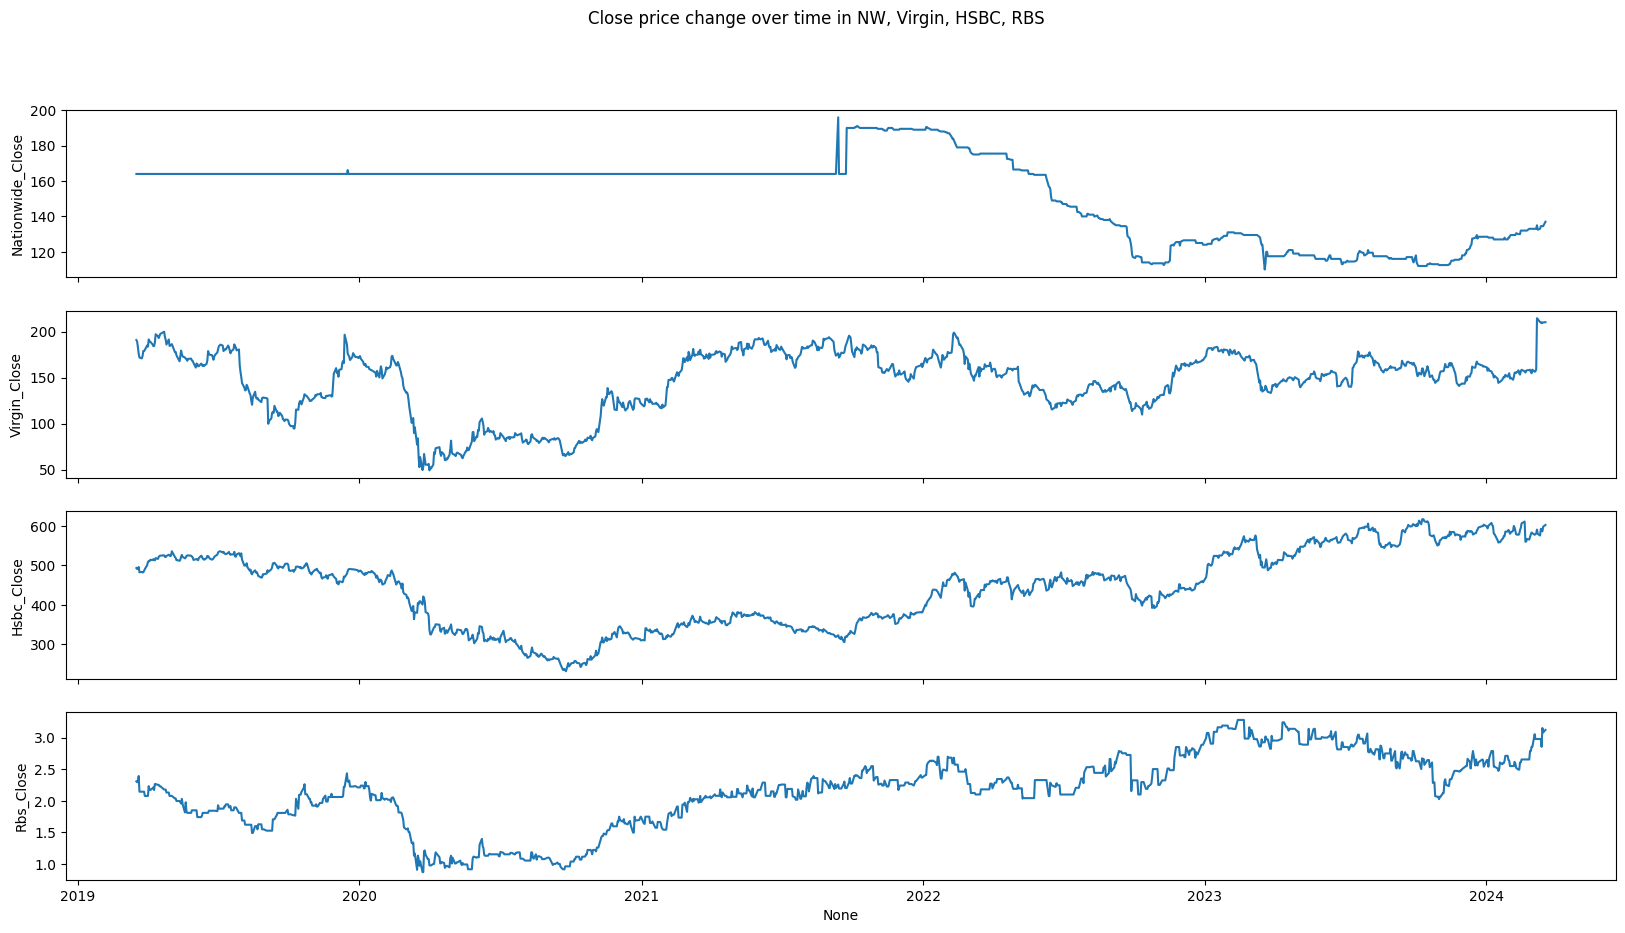

In [14]:

fig, axs = plt.subplots(4,1, figsize=(20,10), sharex=True)
sns.lineplot(data=df_all, x=df_all.index, y='Nationwide_Close', ax=axs[0])
sns.lineplot(data=df_all, x=df_all.index, y='Virgin_Close', ax=axs[1])
sns.lineplot(data=df_all, x=df_all.index, y='Hsbc_Close', ax=axs[2])
sns.lineplot(data=df_all, x=df_all.index, y='Rbs_Close', ax=axs[3])
fig.suptitle('Close price change over time in NW, Virgin, HSBC, RBS')

#### Correlation analysis - makes more sense to work on the returns as this allows us to assume stationarity 
### What is stationarity?

A stationary data set is one where there is a constant mean, variance and constant autocorrelation. 
- The time series does not exhibit trends overtime 
- There is a constant variance and so the amplitude of the series does not vary over time 
- Constant autocorrelation, and so the relationship between the observation and lagged value is the same regardless of what time you calculate the relationship 


#### Testing for stationarity:

In order to test for stationarity we use the adfuller test. The null hypothesis of the AdFuller test is that there is unit root.  

**Unit root**: A time series with unit root is deemed non-stationary. This means properties such as mean and variance can change over time. Therefore, this makes analysis and forecasting is challenging. 

In [36]:
from statsmodels.tsa.stattools import adfuller 
adf_result_hsbc = adfuller(df_all['Percentage_change_Hsbc'][1:])
adf_result_hsbc

# how to interpret these results?


print(f'The test statistic for the adfuller test is:{adf_result_hsbc[0]}. The more negative this is, the stronger the evidence against the null hypothesis.')
print(f'The p-value is {adf_result_hsbc[1]}. A p-value, depending on your confidence. A p-value less than 0.05 suggests that you should reject the null hypothesis. A p-value of 0.0 suggests you should strongly reject the null hypothesis.')
print(f'The number of lags used is {adf_result_hsbc[2]}. The ADF tests selects the optimal lag length that balances completeness of the model.')
print(f'The number of lags used is {adf_result_hsbc[3]}. This value is the number of data points used in the test after accounting for lags.')
print(f'The number of lags used is {adf_result_hsbc[4]}. These are the critical values corresponding to the diffferent levels of confidence for the test.')
print(f"The number of lags used is{adf_result_hsbc[4]['1%']}. These are the critical values at 1% confidence level. If the test statistic for the ADF is below this then we can reject the null hypothesis with 99% confidence")
print(f"The number of lags used is{adf_result_hsbc[4]['5%']}. These are the critical values at 5% confidence level. If the test statistic for the ADF is below this then we can reject the null hypothesis with 95% confidence")
print(f"The number of lags used is{adf_result_hsbc[4]['10%']}. These are the critical values at 10% confidence level. If the test statistic for the ADF is below this then we can reject the null hypothesis with 90% confidence")

The test statistic for the adfuller test is:-36.307923198378276. The more negative this is, the stronger the evidence against the null hypothesis.
The p-value is 0.0. A p-value, depending on your confidence. A p-value less than 0.05 suggests that you should reject the null hypothesis. A p-value of 0.0 suggests you should strongly reject the null hypothesis.
The number of lags used is 0. The ADF tests selects the optimal lag length that balances completeness of the model.
The number of lags used is 1230. This value is the number of data points used in the test after accounting for lags.
The number of lags used is {'1%': -3.4356776419985953, '5%': -2.863892657513944, '10%': -2.5680225884063717}. These are the critical values corresponding to the diffferent levels of confidence for the test.
The number of lags used is-3.4356776419985953. These are the critical values at 1% confidence level. If the test statistic for the ADF is below this then we can reject the null hypothesis with 99% con

In [40]:
# [Task]: Confirm stationarity of the remain returns

In [39]:
# [Task]: Confirm stationarity of the remain returns
adf_result_rbs = adfuller(df_all['Percentage_change_Rbs'][1:])
adf_result_virgin = adfuller(df_all['Percentage_change_Virgin'][1:])
adf_result_nw = adfuller(df_all['Percentage_change_Nationwide'][1:])
adf_result_rbs
adf_result_virgin
adf_result_nw

(-6.515727395733604,
 1.0725799212599415e-08,
 16,
 1214,
 {'1%': -3.4357480073434905,
  '5%': -2.863923702481129,
  '10%': -2.568039121778048},
 3433.5786130071165)

In [56]:
# Run the correlation analysis between the 2 returns

# df_all['Percentage_change_Nationwide'].corr(df_all['Percentage_change_Hsbc'])
# df_all['Percentage_change_Nationwide'].corr(df_all['Percentage_change_Virgin'])
# df_all['Percentage_change_Nationwide'].corr(df_all['Percentage_change_Rbs'])
# df_all['Percentage_change_Nationwide'].corr(df_all['Percentage_change_Santendar'])

df_all.iloc[:,5:len(df_all)].corr()

,Percentage_change_Nationwide,Percentage_change_Virgin,Percentage_change_Hsbc,Percentage_change_Rbs,Percentage_change_Santendar
Percentage_change_Nationwide,1.000000,0.058678,0.056141,0.025488,0.028568
Percentage_change_Virgin,0.058678,1.000000,0.463594,0.391408,0.457061
Percentage_change_Hsbc,0.056141,0.463594,1.000000,0.241136,0.545136
Percentage_change_Rbs,0.025488,0.391408,0.241136,1.000000,0.243586
Percentage_change_Santendar,0.028568,0.457061,0.545136,0.243586,1.000000


In [50]:
# [Discussion]: Interpret the correlation results

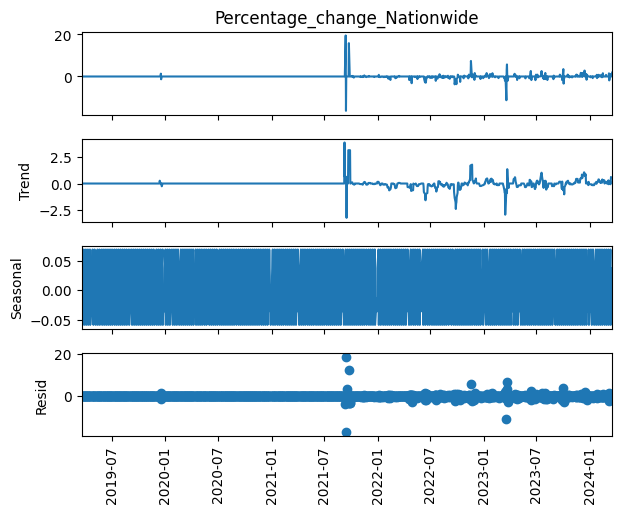

In [67]:
# Time series decomposition on the Nstionwide closing price 

from statsmodels.tsa.seasonal import seasonal_decompose

nw_sd = seasonal_decompose(df_all['Percentage_change_Nationwide'][1:], period=5, model='additive')
nw_sd.plot()
plt.xticks(rotation=90);

#### How to decide between multiplicative and additive seasonal decompositions?

- An additive model is used when the seasonal variations are roughly constant throughout a series
- It works well with time series data where the magnitude of the seasonal pattern doesn't change over time
- A multiplicative model is used when the seasonal variation increase of decrease over time. 

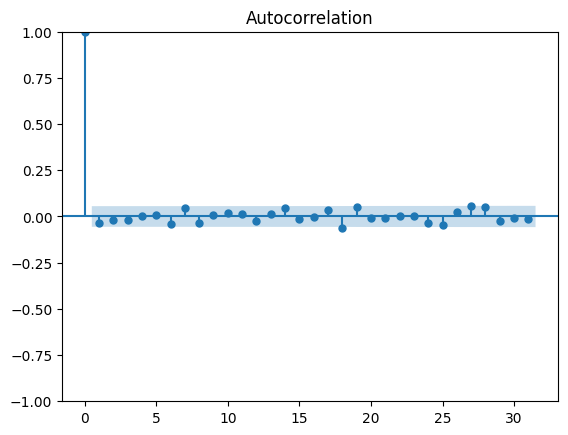

In [107]:
# Plot the ACF and the PACF:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_all['Percentage_change_Hsbc'][1:]);


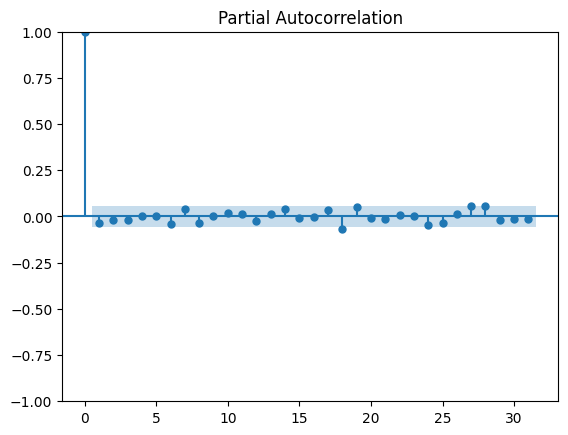

In [108]:
plot_pacf(df_all['Percentage_change_Hsbc'][1:]);
# Efficient market hypothesis: The lack of autocorrelation in share price returns suggests that you can't analyse the stock market in this manner
# Instead we need to identify alternative forecasting tools

In [124]:
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA


AR_models = {}
for i in range(1,10):
    model = ARIMA(df_all['Percentage_change_Hsbc'][i:], order=(i,0,0))
    fit_result = model.fit()
    summary = fit_result.summary()
    AR_models[f'AR_nw_{i}'] = {
        'model': f'{i},0,0',
        'AIC': fit_result.aic, 
        'BIC': fit_result.bic, 
        'Log Liklihood': fit_result.llf}
    # AR_models[f'AR_nw_{i}']['summary'] = AR_models[f'AR_nw_{i}'].summary()

    
# Understand AR models 
'''

 - In the example above we have built an AR model of order 4
 - What is an AR model? 
 - Please see page 6 of the guide, for a visual demostration on this
 - What do the outputs of the model showcase?


'''

/home/vaishnavi/python_environments/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vaishnavi/python_environments/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vaishnavi/python_environments/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vaishnavi/python_environments/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date in

'\n\n - In the example above we have built an AR model of order 4\n - What is an AR model? \n - Please see page 6 of the guide, for a visual demostration on this\n - What do the outputs of the model showcase?\n\n\n'

In [ ]:
# interpret this result 
# what does this mean?
# evaluate the model    
AR_models 


/home/vaishnavi/python_environments/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vaishnavi/python_environments/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vaishnavi/python_environments/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


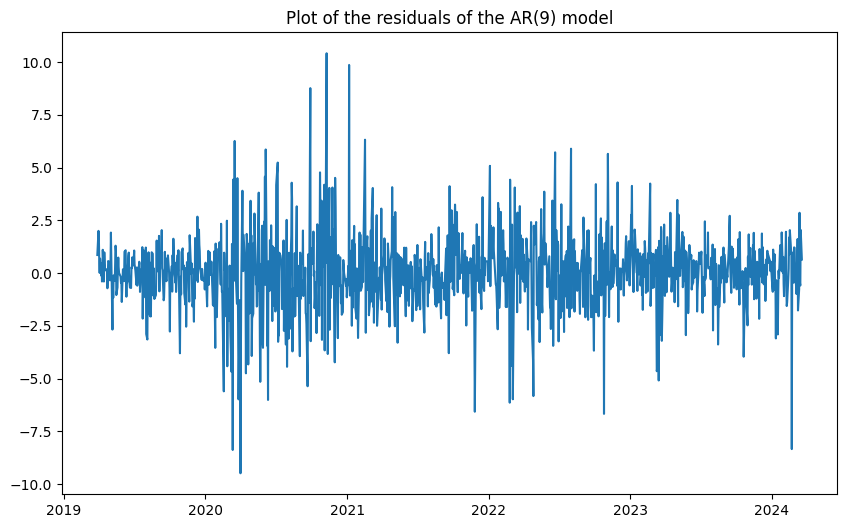

In [131]:
# Review the residuals of the AR(9) mode]

AR_nw_9 = ARIMA(df_all['Percentage_change_Hsbc'][9:], order=(9,0,0))
AR_nw_9_results = AR_nw_9.fit()
resid = AR_nw_9_results.resid
plt.figure(figsize = (10,6))
plt.plot(resid)
plt.title('Plot of the residuals of the AR(9) model');

In [137]:
# Check the summary statistics of the AR(9) model
print(resid.describe())
print(resid.var()) # the mean and variance for the residuals for a well fitting model should be close to 0

count    1223.000000
mean        0.000232
std         1.782814
min        -9.491454
25%        -0.836815
50%         0.035358
75%         0.881167
max        10.422292
dtype: float64
3.1784264116309453


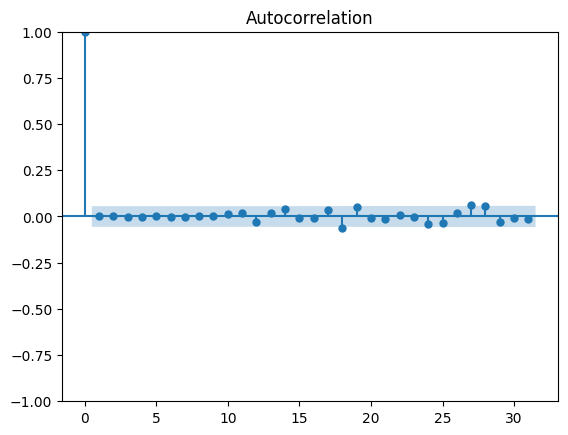

In [140]:
plot_acf(resid); # looks good - there are no spikes outside the significant confidence intervals

<Axes: >

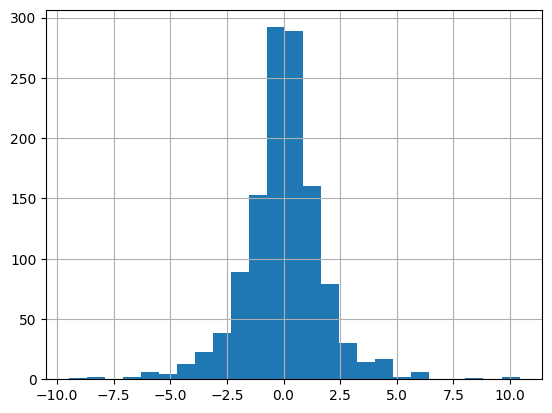

In [142]:
resid.hist(bins=25) # The residuals should be normally distributes and around 0

((array([-3.25518171, -2.99431589, -2.84901763, ...,  2.84901763,
          2.99431589,  3.25518171]),
  array([-9.49145432, -8.38655883, -8.34405245, ...,  8.76980289,
          9.86805493, 10.42229191])),
 (1.7329248563531066, 0.00023168410743242218, 0.9701496396124526))

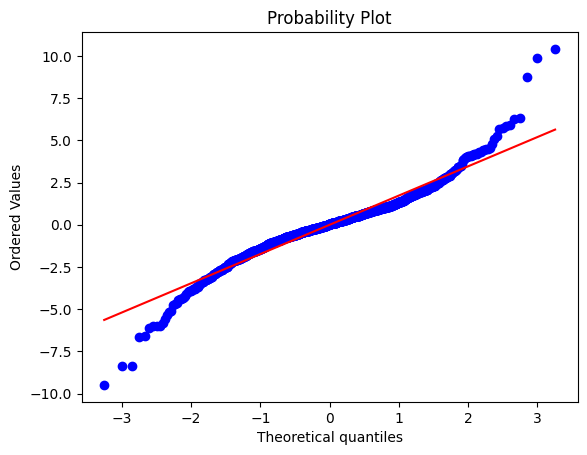

In [144]:
import scipy.stats as stats 
stats.probplot(resid, dist='norm', plot=plt) # points close to the red line show a normal distribution

In [ ]:
# Create a moving average model for the 